In [1]:
using CSV, DataFrames, Statistics
using PyPlot # plotting library
using PyCall
using Printf
using FStrings
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

#make jupyter notebook print more dataframe columns
ENV["COLUMNS"]=160

# important attributes for this analysis
hand = "2v2"
subjects = ["sub1", "sub2", "sub3"]
t_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]
rotations = ["n"]
translations = ['a','b','c','d','e','f','g','h']

metrics = [:dist, :arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :t_fd]

metric_to_color = Dict(:dist=>"xkcd:tan", :arc_len=>"xkcd:light blue", :area_btwn=>"xkcd:dark red", :max_a_loc=>"xkcd:light green", :max_a_reg=>"xkcd:dark green", :max_err=>"xkcd:blue grey", :mvt_eff=>"xkcd:dark orange", :r_fd=>"xkcd:red brown", :t_fd=>"xkcd:brown")


print("Ready to go!")

Ready to go!

-----

# Reading in the Data
Now reading in the metrics data for 2v2.

In [2]:
df_hand = CSV.read(f"results/{hand}_metrics.csv", DataFrame, copycols=true)
first(df_hand, 23)

,trial,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_2v2_a_n_1,0.748291,0.0168483,0.363636,0.654545,0.0025875,0.0235,0.485956,4.9329,0.0235679
2,sub1_2v2_a_n_2,0.697183,0.018311,0.358586,0.652626,0.00233626,0.02,0.514335,5.2424,0.0207902
3,sub1_2v2_a_n_3,0.716414,0.0164827,0.373737,0.672727,0.00339716,0.0088,0.521678,5.6809,0.030014
4,sub1_2v2_a_n_4,0.628966,0.0186099,0.388889,0.7,0.0035062,0.0094,0.618299,3.7641,0.0496735
5,sub1_2v2_a_n_5,0.769194,0.024214,0.383838,0.690909,0.00267586,0.0359,0.499014,5.7344,0.035901
6,sub2_2v2_a_n_1,0.554563,0.00733035,0.313131,0.563636,0.00161067,0.0135,0.564645,5.7871,0.0151927
7,sub2_2v2_a_n_2,1.10401,0.0369604,0.232323,0.422828,0.00244743,0.0324,0.210435,5.4755,0.134735
8,sub2_2v2_a_n_3,0.998397,0.0371125,0.262626,0.47798,0.00216985,0.0224,0.263048,5.2678,0.0794814
9,sub2_2v2_a_n_4,0.593701,0.00985501,0.323232,0.581818,0.00206752,0.0329,0.544436,4.256,0.0402962


In [3]:
# breaking out important info from the trial id for easier data access
subject_nums = []
translation_labels = []
numbers = []

for row in eachrow(df_hand)
    label = row[:trial]
    #sub1_2v2_a_n_1
#     push!(subject_nums, x[4])
#     push!(translation_labels,x[10])
#     push!(numbers, x[14])
    x = split(label, "_")
    push!(subject_nums, x[1][4])
    push!(translation_labels, x[3][1])
    push!(numbers, x[5][1])
end
s = convert(Array{Char,1}, subject_nums)
d = convert(Array{Char,1}, translation_labels)
n = convert(Array{Char,1}, numbers)

insertcols!(df_hand, 2, :subj=>s)
insertcols!(df_hand, 3, :dir=>d)
insertcols!(df_hand, 4, :num=>n)
first(df_hand, 2)

,trial,subj,dir,num,arc_len,area_btwn,dist,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_2v2_a_n_1,1,a,1,0.748291,0.0168483,0.363636,0.654545,0.0025875,0.0235,0.485956,4.9329,0.0235679
2,sub1_2v2_a_n_2,1,a,2,0.697183,0.018311,0.358586,0.652626,0.00233626,0.02,0.514335,5.2424,0.0207902


## Asterisk Plot

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

-----

# Histograms of Metrics
Now I will produce histogram plots of the metrics to see what kind of a distribution we get for all the trials.
Shamelessly taken from my previous datascience course at: [link](https://github.com/SimonEnsemble/data_science_course)

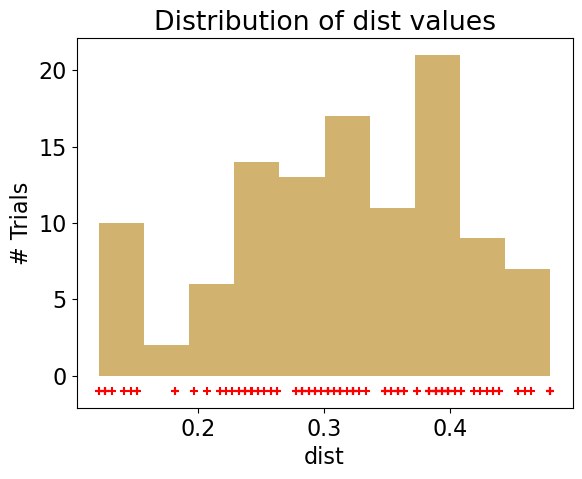

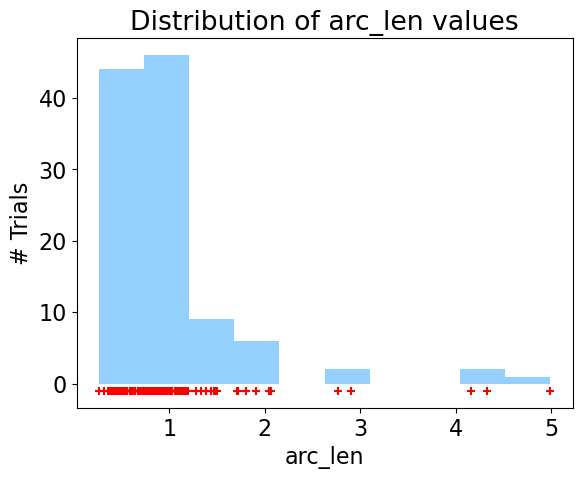

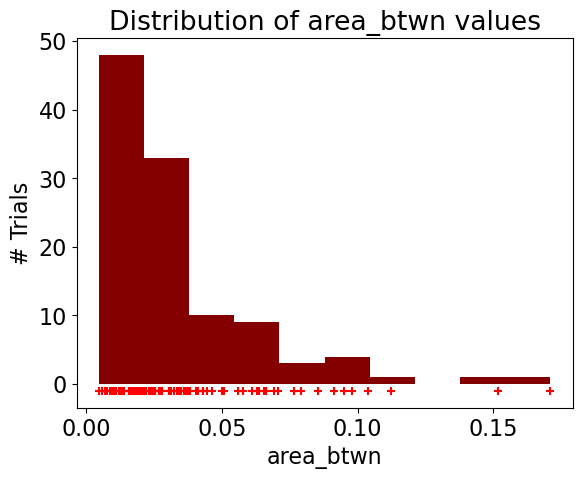

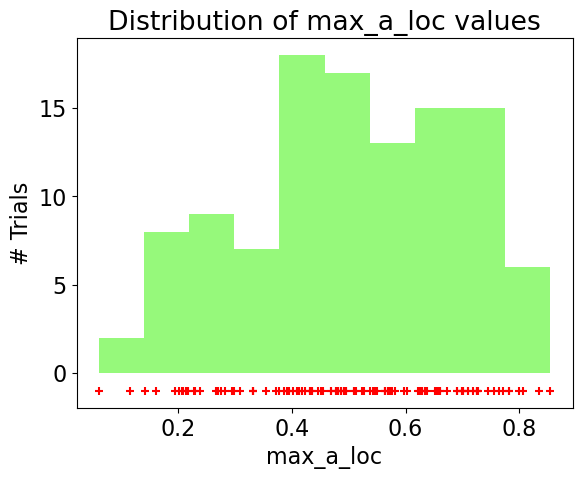

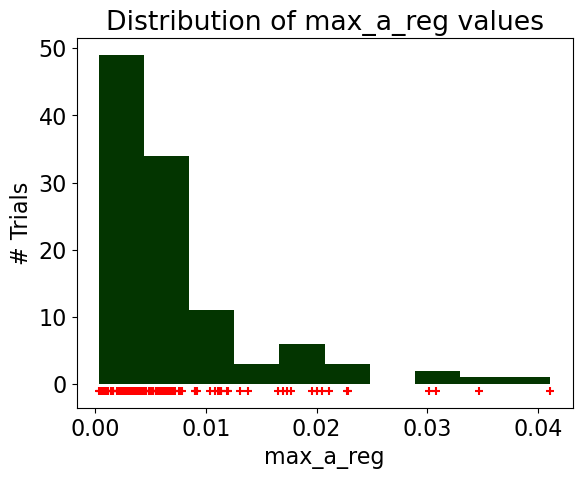

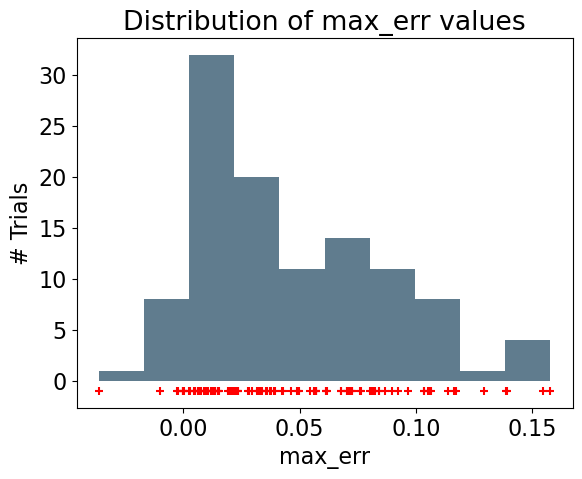

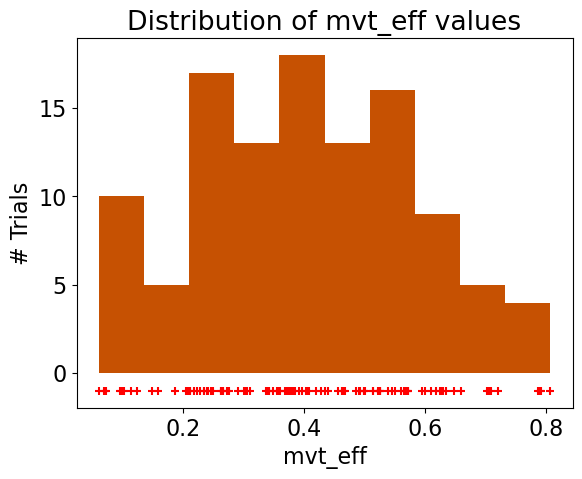

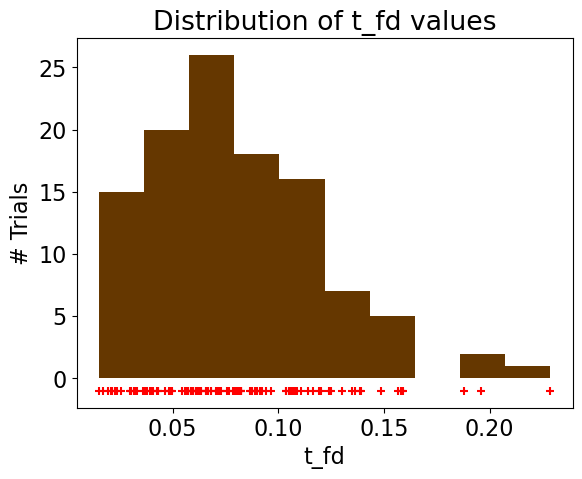

In [4]:

for m in metrics
    figure()
    hist(df_hand[:, m], color=metric_to_color[m]) #, normed=true)
    scatter(df_hand[:, m], [-1 for i = 1:nrow(df_hand)], marker="+", color="r")
    xlabel(f"{m}")
    ylabel("# Trials")
    title(f"Distribution of {m} values")
end

### Observations of Histogram Plots
Based on what I see, here are the observations per metric (in order of appearance top to down):
* **total distance**: values are distributed
* **arc length**: mostly concentrated at low arc lengths
* **max area region location**: mostly, the region of max error area is most commonly found at the end
* **max area region**: at the locations of max error area, the area of error (aka the area between the path and the target line) is still relatively low
* **max error**: values are distributed
* **movement efficiency**: values are distributed
* **rotational frechet distance**: aka max rotation error. Mostly low, but larger distribution at the low end
* translational frechet distance: all values are very low

----

# Metric Values by direction
Plot all metric values in bar charts by direction

In [5]:
# groups = groupby(df_hand, :dir)
# a_df = groups[1]
# b_df = groups[2]
# c_df = groups[3]
# d_df = groups[4]
# e_df = groups[5]
# f_df = groups[6]
# g_df = groups[7]
# h_df = groups[8]
# directions = [a_df, b_df, c_df, d_df, e_df, f_df, g_df, h_df]
# a_df

In [6]:
function compare_metrics(metric::Symbol, df::DataFrame) 
    dir_data = groupby(df, :dir)
    metric_data = []
    
    for dir in dir_data
        data = dir[!, metric]
        push!(metric_data, data)
    end
    plt_title = f"{hand}: {metric}"
    boxplot(metric_data)
    title(plt_title)
    xticks(1:8, t_labels)
    xlabel("Trial Directions")
end

println("Functions are ready!")

Functions are ready!


In [7]:
subjects = ["sub1", "sub2", "sub3"]
translations = ['a','b','c','d','e','f','g','h']
rotations = ["n"]

function get_trial_vals(df::DataFrame, metric::Symbol, translation::Char)
    desired_direction = filter(row -> row[:dir] == translation, df)
    names = desired_direction[!, :trial]
    values = desired_direction[!, metric]
    v = convert(Array{Float64,1}, values)  # just in case
    
    return v, names
end

print("Functions are ready!")

Functions are ready!

-----

# Average Line Calculations

#### Dir: A
![Average Debug Plot for direction A](./pics/avgdebug_2v2_3subs_a_n.jpg)

#### Dir: B
![Average Debug Plot for direction B](./pics/avgdebug_2v2_3subs_b_n.jpg)

#### Dir: C
![Average Debug Plot for direction C](./pics/avgdebug_2v2_3subs_c_n.jpg)

#### Dir: D
![Average Debug Plot for direction D](./pics/avgdebug_2v2_3subs_d_n.jpg)

#### Dir: E
![Average Debug Plot for direction E](./pics/avgdebug_2v2_3subs_e_n.jpg)

#### Dir: F
![Average Debug Plot for direction F](./pics/avgdebug_2v2_3subs_f_n.jpg)

#### Dir: G
![Average Debug Plot for direction G](./pics/avgdebug_2v2_3subs_g_n.jpg)

#### Dir: H
![Average Debug Plot for direction H](./pics/avgdebug_2v2_3subs_h_n.jpg)


----

# T Tests for Symmetry

In [8]:
using HypothesisTests

In [9]:
function compare_2_directions(metric::Symbol)
    translations = ['a','b','c','d','e','f','g','h']
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            v1, _ = get_trial_vals(df_hand, metric, t)
            v2, _ = get_trial_vals(df_hand, metric, t2)
            
            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            results_report[i, i+n] = r
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end

# temp = compare_2_directions(:arc_len)
println("Functions are ready!")

Functions are ready!


In [10]:
# for m in metrics
#     maxes = []
#     mins = []
#     r = compare_2_directions(m)
    
#     println(f"{m} data")
#     println("   ")
#     println(r)
#     println("================================================")
#     println("    ")
# end

----

# Data Analysis 

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

**Hypotheses:**
* df

### Total Distance Travelled


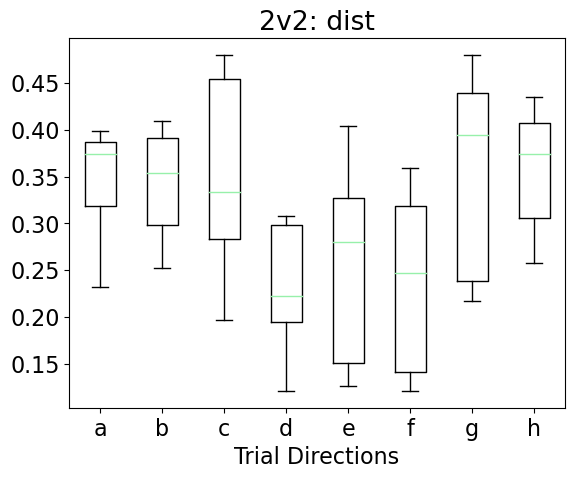

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.7987,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.9137,0.7855,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0001,0.0001,0.0015,1.0,0.0,0.0,0.0,0.0
5,e,0.0053,0.0078,0.0174,0.4561,1.0,0.0,0.0,0.0
6,f,0.0017,0.0026,0.0072,0.7287,0.7189,1.0,0.0,0.0
7,g,0.8703,0.7474,0.9626,0.0016,0.0173,0.0073,1.0,0.0
8,h,0.6008,0.4441,0.8099,0.0,0.0025,0.0008,0.8598,1.0


In [11]:
compare_metrics(:dist, df_hand)
compare_2_directions(:dist)

### Arc Length

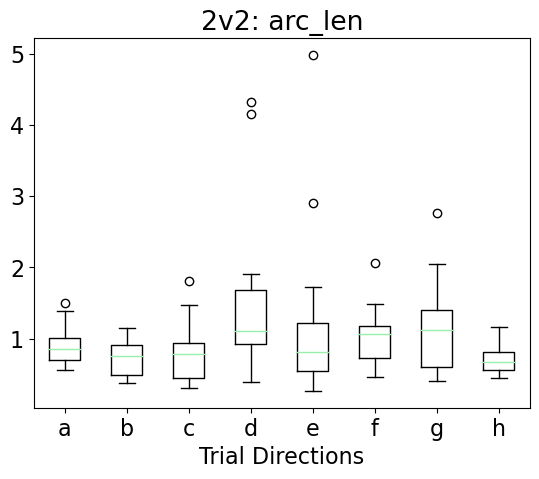

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.1106,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.5527,0.6016,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0952,0.0492,0.0712,1.0,0.0,0.0,0.0,0.0
5,e,0.3457,0.1728,0.2572,0.4428,1.0,0.0,0.0,0.0
6,f,0.2175,0.0218,0.1373,0.1948,0.6512,1.0,0.0,0.0
7,g,0.1989,0.0443,0.1274,0.2846,0.8385,0.6924,1.0,0.0
8,h,0.0601,0.8138,0.4952,0.0449,0.1558,0.0141,0.0346,1.0


In [12]:
compare_metrics(:arc_len, df_hand)
compare_2_directions(:arc_len)

### Movement Efficiency
total_distance / arc_length

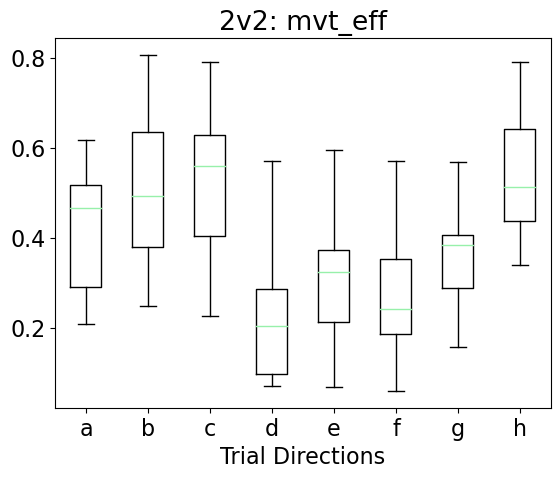

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.0956,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.154,0.8777,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0021,0.0001,0.0002,1.0,0.0,0.0,0.0,0.0
5,e,0.0624,0.0029,0.0061,0.1464,1.0,0.0,0.0,0.0
6,f,0.0061,0.0002,0.0007,0.4413,0.4228,1.0,0.0,0.0
7,g,0.1932,0.0074,0.0169,0.0194,0.3896,0.0709,1.0,0.0
8,h,0.0296,0.7713,0.6568,0.0,0.0006,0.0,0.001,1.0


In [13]:
compare_metrics(:mvt_eff, df_hand)
compare_2_directions(:mvt_eff)

### Max Error

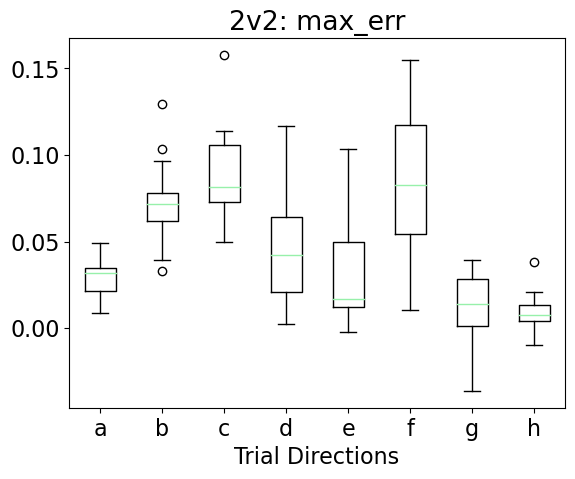

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0,0.138,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0987,0.065,0.007,1.0,0.0,0.0,0.0,0.0
5,e,0.6336,0.0016,0.0001,0.2911,1.0,0.0,0.0,0.0
6,f,0.0007,0.4029,0.8164,0.0376,0.0031,1.0,0.0,0.0
7,g,0.0236,0.0,0.0,0.0104,0.0767,0.0001,1.0,0.0
8,h,0.0001,0.0,0.0,0.0045,0.0258,0.0001,0.5257,1.0


In [14]:
compare_metrics(:max_err, df_hand)
compare_2_directions(:max_err)

### Translational Frechet Distance

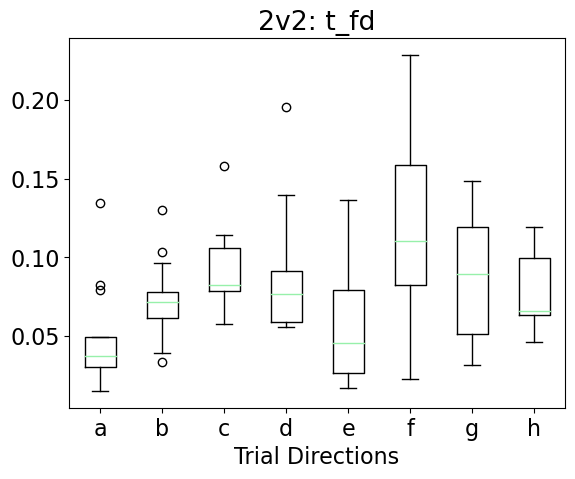

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.0183,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0004,0.0733,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0142,0.2842,0.8976,1.0,0.0,0.0,0.0,0.0
5,e,0.4687,0.166,0.0086,0.0584,1.0,0.0,0.0,0.0
6,f,0.0005,0.0108,0.092,0.1211,0.002,1.0,0.0,0.0
7,g,0.0062,0.2768,0.7282,0.8816,0.0435,0.0741,1.0,0.0
8,h,0.0027,0.4069,0.2615,0.5471,0.0466,0.0251,0.6034,1.0


In [15]:
compare_metrics(:t_fd, df_hand)
compare_2_directions(:t_fd)

### Total Area Between Curves
Between object path and target line

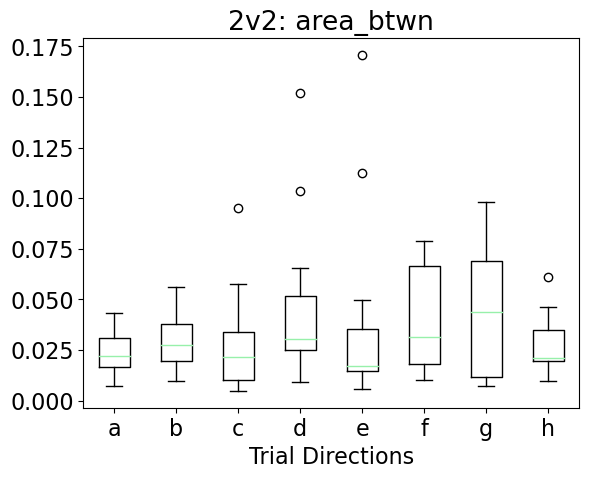

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.2484,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.5492,0.9265,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0938,0.1806,0.1948,1.0,0.0,0.0,0.0,0.0
5,e,0.3065,0.5273,0.5294,0.558,1.0,0.0,0.0,0.0
6,f,0.071,0.2437,0.3085,0.5228,0.9414,1.0,0.0,0.0
7,g,0.0416,0.121,0.1571,0.8359,0.6363,0.5861,1.0,0.0
8,h,0.4152,0.774,0.9249,0.1531,0.4612,0.185,0.0941,1.0


In [16]:
compare_metrics(:area_btwn, df_hand)
compare_2_directions(:area_btwn)

### Max Area Region
The area between the curves of a scrolling window of about 20% total_distance width.

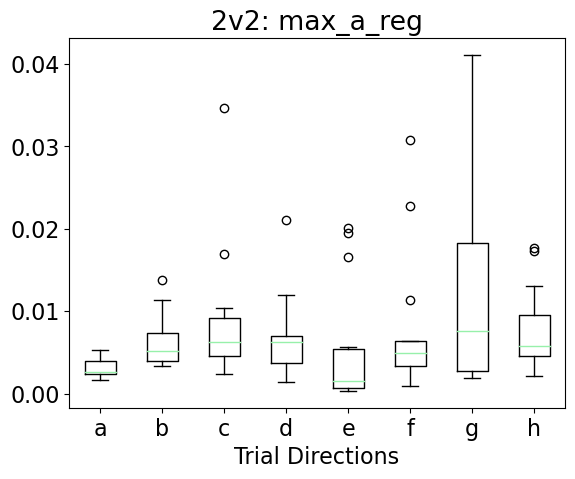

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.0018,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0294,0.3036,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0464,0.7719,0.4677,1.0,0.0,0.0,0.0,0.0
5,e,0.2995,0.6289,0.2391,0.5407,1.0,0.0,0.0,0.0
6,f,0.0711,0.5319,0.7665,0.71,0.3983,1.0,0.0,0.0
7,g,0.0164,0.1086,0.4597,0.1713,0.0889,0.3291,1.0,0.0
8,h,0.0028,0.3789,0.6246,0.7022,0.3171,0.9111,0.2262,1.0


In [17]:
compare_metrics(:max_a_reg, df_hand)
compare_2_directions(:max_a_reg)

### Max Area Location
The location of the center of the max area region, represented as a percentage along the full target line (that is, some percentage of 0.5).

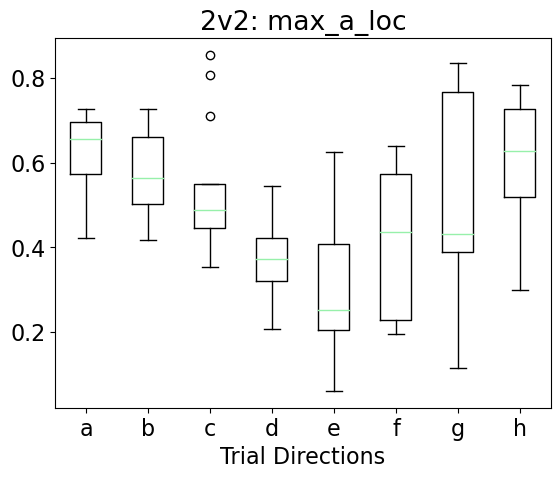

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.1844,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.0845,0.4073,1.0,0.0,0.0,0.0,0.0,0.0
4,d,0.0,0.0,0.0042,1.0,0.0,0.0,0.0,0.0
5,e,0.0,0.0,0.0009,0.2183,1.0,0.0,0.0,0.0
6,f,0.0015,0.0111,0.1002,0.3225,0.0711,1.0,0.0,0.0
7,g,0.119,0.3684,0.7971,0.046,0.0104,0.2611,1.0,0.0
8,h,0.6755,0.5212,0.2191,0.0,0.0,0.0061,0.221,1.0


In [18]:
compare_metrics(:max_a_loc, df_hand)
compare_2_directions(:max_a_loc)

-----

## Comparing PValues Directly, Direction to Direction, all Metrics

In [19]:
translations = ['a','b','c','d','e','f','g','h']
results_report = zeros(8, 8)

for t in translations
    i = findall(x->x==t, translations)[1]
    n = 0

    for t2 in translations[(i+1):end]
        println(f"{t} v {t2}")
        for m in metrics
            v1, _ = get_trial_vals(df_hand, m, t)
            v2, _ = get_trial_vals(df_hand, m, t2)

            result = pvalue(UnequalVarianceTTest(v1, v2))
            r = round(result, digits=4)
            println(f"{m} => {r}")
        end

        println("  ")
    end
    println("====================")
end

a v b
dist => 0.7987
arc_len => 0.1106
area_btwn => 0.2484
max_a_loc => 0.1844
max_a_reg => 0.0018
max_err => 0.0
mvt_eff => 0.0956
t_fd => 0.0183
  
a v c
dist => 0.9137
arc_len => 0.5527
area_btwn => 0.5492
max_a_loc => 0.0845
max_a_reg => 0.0294
max_err => 0.0
mvt_eff => 0.154
t_fd => 0.0004
  
a v d
dist => 0.0001
arc_len => 0.0952
area_btwn => 0.0938
max_a_loc => 0.0
max_a_reg => 0.0464
max_err => 0.0987
mvt_eff => 0.0021
t_fd => 0.0142
  
a v e
dist => 0.0053
arc_len => 0.3457
area_btwn => 0.3065
max_a_loc => 0.0
max_a_reg => 0.2995
max_err => 0.6336
mvt_eff => 0.0624
t_fd => 0.4687
  
a v f
dist => 0.0017
arc_len => 0.2175
area_btwn => 0.071
max_a_loc => 0.0015
max_a_reg => 0.0711
max_err => 0.0007
mvt_eff => 0.0061
t_fd => 0.0005
  
a v g
dist => 0.8703
arc_len => 0.1989
area_btwn => 0.0416
max_a_loc => 0.119
max_a_reg => 0.0164
max_err => 0.0236
mvt_eff => 0.1932
t_fd => 0.0062
  
a v h
dist => 0.6008
arc_len => 0.0601
area_btwn => 0.4152
max_a_loc => 0.6755
max_a_reg => 0.002

In [20]:
function aggregate_pvalues()
    translations = ['a','b','c','d','e','f','g','h']
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            total_sigs = 0
            
            for m in metrics
                v1, _ = get_trial_vals(df_hand, m, t)
                v2, _ = get_trial_vals(df_hand, m, t2)

                result = pvalue(UnequalVarianceTTest(v1, v2))
                
                if result <= 0.05
                    total_sigs = total_sigs + 1
                end
                
                if t == t2
                    total_sigs = NaN
                end
            end
            perc_sigs = total_sigs / length(metrics)
            results_report[i, i+n] = perc_sigs
            
            n = n+1
        end
        println(" ")
    end

    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end

aggregate_results = aggregate_pvalues()

,trials,a,b,c,d,e,f,g,h
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,a,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b,0.375,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,c,0.375,0.0,NaN,0.0,0.0,0.0,0.0,0.0
4,d,0.625,0.5,0.5,NaN,0.0,0.0,0.0,0.0
5,e,0.25,0.5,0.625,0.0,NaN,0.0,0.0,0.0
6,f,0.625,0.625,0.25,0.125,0.25,NaN,0.0,0.0
7,g,0.5,0.375,0.25,0.5,0.375,0.25,NaN,0.0
8,h,0.5,0.125,0.125,0.625,0.625,0.75,0.25,NaN


In [42]:
colormap = PyPlot.matplotlib.cm.get_cmap("bwr")
colors = colormap.(reverse(range(0.1, stop=0.9, length=10)))

0.0

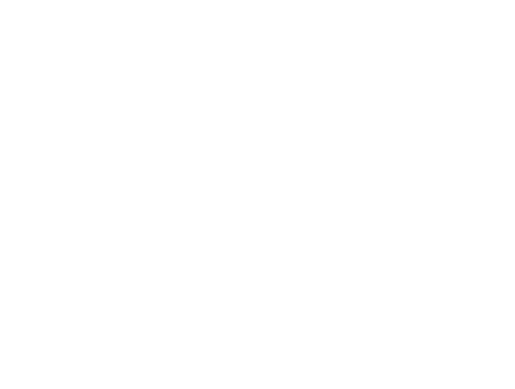

8×9 Array{Any,2}:
 "a"  NaN        0.0      0.0      0.0      0.0      0.0     0.0     0.0
 "b"    0.375  NaN        0.0      0.0      0.0      0.0     0.0     0.0
 "c"    0.375    0.0    NaN        0.0      0.0      0.0     0.0     0.0
 "d"    0.625    0.5      0.5    NaN        0.0      0.0     0.0     0.0
 "e"    0.25     0.5      0.625    0.0    NaN        0.0     0.0     0.0
 "f"    0.625    0.625    0.25     0.125    0.25   NaN       0.0     0.0
 "g"    0.5      0.375    0.25     0.5      0.375    0.25  NaN       0.0
 "h"    0.5      0.125    0.125    0.625    0.625    0.75    0.25  NaN

In [49]:
# make a nice table with color coding, highlighting directions that have and don't have significant differences from each other

fig, ax = subplots()

# Hide axes because there isn't a plot to go with it
ax.axis("off")

results_table = convert(Matrix, aggregate_results)
# the_table = table(results_table, colLabels=names(aggregate_results))

# the_table.get_celld()[(1,0)].set_facecolor("#56b5fd")

# colormap = PyPlot.matplotlib.cm.get_cmap("bwr")

# for i in range(1, stop=8)
#     for j in range(1, stop=9)
#         val = aggregate_results[i,j]
        
#         if typeof(val) == String
#             c = "xkcd:grey blue"
#         elseif isnan(val)
#             c = "xkcd:dark grey"
#         else
#             c = colormap(val)
#         end
        
#         the_table.get_celld()[(i-1,j-1)].set_facecolor(c)
#     end
# end


![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

# Clustering for Symmetry

In [22]:
using Clustering

# use kmeans or hierarchical clustering single linkage?

In [23]:
test = [1, 2, 3, 4, 5]
t = 2
i = findall(x->x!=t, test)

4-element Array{Int64,1}:
 1
 3
 4
 5